In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchtext.data import Field, BucketIterator
from sklearn.model_selection import train_test_split, KFold
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import F1Score
import warnings
import optuna
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
from utils import *

# Import data

In [3]:
FOLDS = 5 # number of folds for CV (== number of fusions tried)
SEED = 2022

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# import data
data = import_data()

In [6]:
%%time
# preprocessing (tokenization, discard long sentence, lowercase etc.)
data = preproc(data)

Tokenizing the data...
Length of the data :  29544
CPU times: total: 3min 39s
Wall time: 3min 42s


In [16]:
%%time
# data split (CV)
datasets = []
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for i, (train_indices, test_indices) in enumerate(cv.split(data)):
    train_set, test_set = data.loc[train_indices, :], data.loc[test_indices, :]

    datasets.append((train_set, test_set))

CPU times: total: 15.6 ms
Wall time: 19.5 ms


# CV

### Definition

In [17]:
LEARNING_RATE = 2e-4 # starting learning rate for scheduler
EPOCHS = 'unrestricted' # use 'unrestricted' for full convergence
N_HEADS = 4

In [18]:
# template for training parent models (as we train them the same way)
def train_early_stopping(model_name: str, train_iter, valid_iter, embedding, pad_idx, voc_size, device, lr=2e-4, save=True):
    # init
    model = new_model(embedding, pad_idx, voc_size, device, n_head=N_HEADS) # init model

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # train with early stopping
    history = train(model=model,
                    iterator=train_iter,
                    valid_iter=valid_iter,
                    optimizer=opt,
                    criterion=loss_fn,
                    epoch=EPOCHS,
                    clip=1,
                    device=device)

    if save:
        # save model
        name = f'parallel_training/model{model_name}_IMDB_256'
        save_model(model, name=name)

        # save history
        name = f'parallel_training/history_model{model_name}_IMDB_256'
        save_history(history, name=name)

    return model

### Evaluation

In [19]:
model_names = ['A', 'B', 'vanilla_pre', 'vanilla_post', 'OT_pre (method 1)', 'OT_post (method 1)', 'OT_pre (method 2)', 'OT_post (method 2)', 'OT_pre (method 3)', 'OT_post (method 3)', 'random']
scores = {'loss': {model_name: [] for model_name in model_names},
          'accuracy': {model_name: [] for model_name in model_names},
          'f1': {model_name: [] for model_name in model_names},}

Fold 1/5
Vocabulary Size :  23044


100%|██████████| 5908/5908 [00:00<00:00, 20163.71it/s]


Positive labels ratio (train set): 0.5019461837874429
Positive labels ratio (test set): 0.506093432633717
Dataset initializing done
Starting training for model A


Epoch: 96 - Train Loss: 0.1764 / Validation Loss: 0.4852 / Train acc: 0.9349 / Val acc: 0.8149 / Learning Rate : 0.0000:   0%|          | 96/1000000 [03:30<604:25:34,  2.18s/it]

Training has converged after 96 epochs (lr < 1e-06)


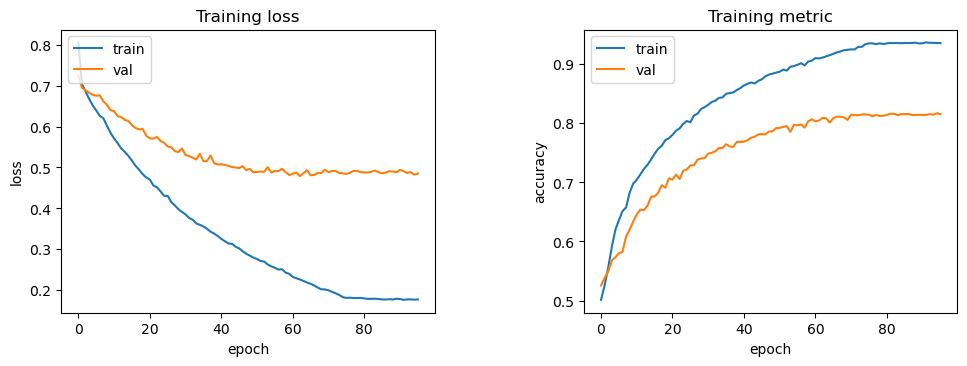

Epoch: 96 - Train Loss: 0.1764 / Validation Loss: 0.4852 / Train acc: 0.9349 / Val acc: 0.8149 / Learning Rate : 0.0000:   0%|          | 96/1000000 [03:30<608:44:00,  2.19s/it]


Starting training for model B


Epoch: 46 - Train Loss: 0.1516 / Validation Loss: 0.4002 / Train acc: 0.9470 / Val acc: 0.8469 / Learning Rate : 0.0000:   0%|          | 46/1000000 [01:40<628:45:10,  2.26s/it]

Training has converged after 46 epochs (lr < 1e-06)


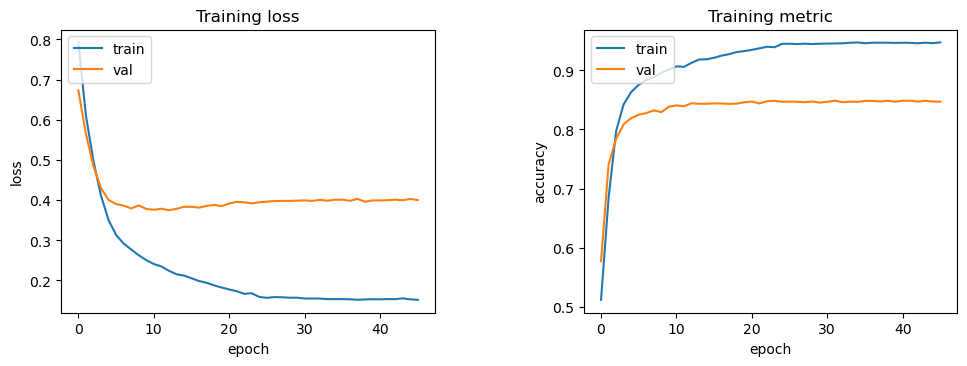

Epoch: 46 - Train Loss: 0.1516 / Validation Loss: 0.4002 / Train acc: 0.9470 / Val acc: 0.8469 / Learning Rate : 0.0000:   0%|          | 46/1000000 [01:40<609:37:39,  2.19s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.7937840198228122
fusion successful
fusion success

Epoch: 134 - Train Loss: 0.1993 / Validation Loss: 0.4577 / Train acc: 0.9325 / Val acc: 0.7995 / Learning Rate : 0.0000:   0%|          | 134/1000000 [04:52<575:13:09,  2.07s/it]

Training has converged after 134 epochs (lr < 1e-06)


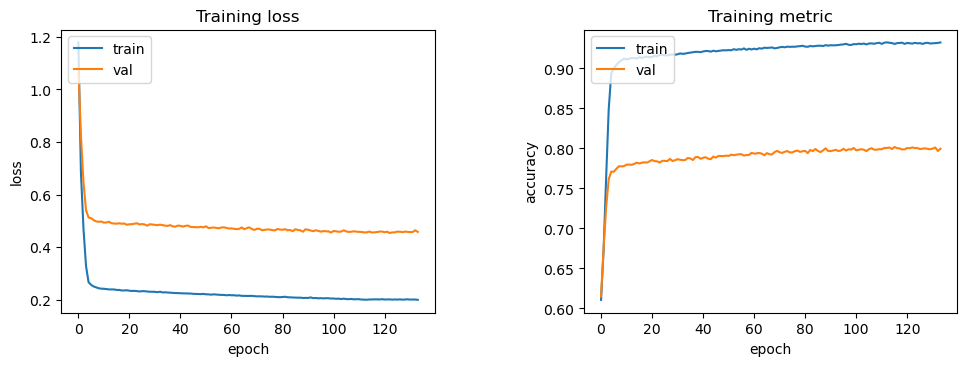

Epoch: 134 - Train Loss: 0.1993 / Validation Loss: 0.4577 / Train acc: 0.9325 / Val acc: 0.7995 / Learning Rate : 0.0000:   0%|          | 134/1000000 [04:52<606:23:40,  2.18s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 164 - Train Loss: 0.1676 / Validation Loss: 0.4418 / Train acc: 0.9434 / Val acc: 0.8202 / Learning Rate : 0.0000:   0%|          | 164/1000000 [05:39<583:43:27,  2.10s/it]

Training has converged after 164 epochs (lr < 1e-06)


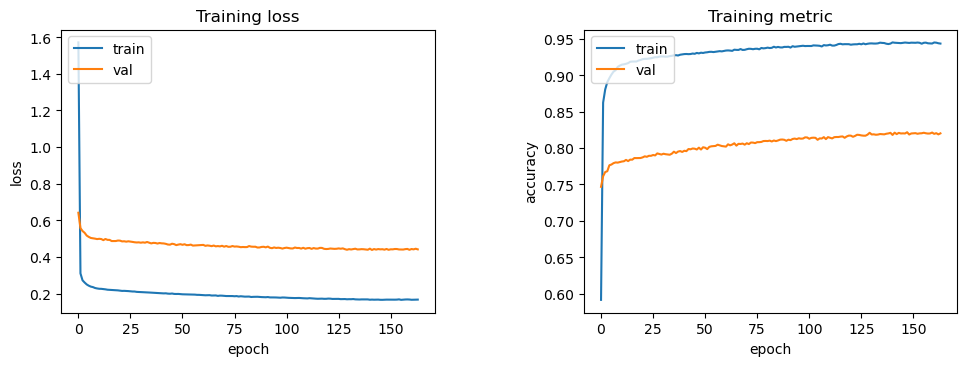

Epoch: 164 - Train Loss: 0.1676 / Validation Loss: 0.4418 / Train acc: 0.9434 / Val acc: 0.8202 / Learning Rate : 0.0000:   0%|          | 164/1000000 [05:39<575:40:43,  2.07s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 211 - Train Loss: 0.1609 / Validation Loss: 0.4384 / Train acc: 0.9459 / Val acc: 0.8239 / Learning Rate : 0.0000:   0%|          | 211/1000000 [07:20<584:18:04,  2.10s/it]

Training has converged after 211 epochs (lr < 1e-06)


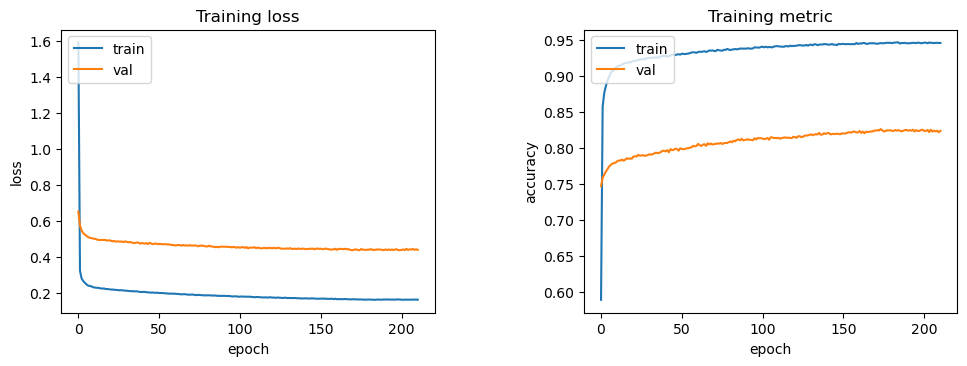

Epoch: 211 - Train Loss: 0.1609 / Validation Loss: 0.4384 / Train acc: 0.9459 / Val acc: 0.8239 / Learning Rate : 0.0000:   0%|          | 211/1000000 [07:21<580:33:36,  2.09s/it]


Starting retraining for model OT fusion (method 3)


Epoch: 162 - Train Loss: 0.1685 / Validation Loss: 0.4454 / Train acc: 0.9447 / Val acc: 0.8173 / Learning Rate : 0.0000:   0%|          | 162/1000000 [05:42<576:08:12,  2.07s/it]

Training has converged after 162 epochs (lr < 1e-06)


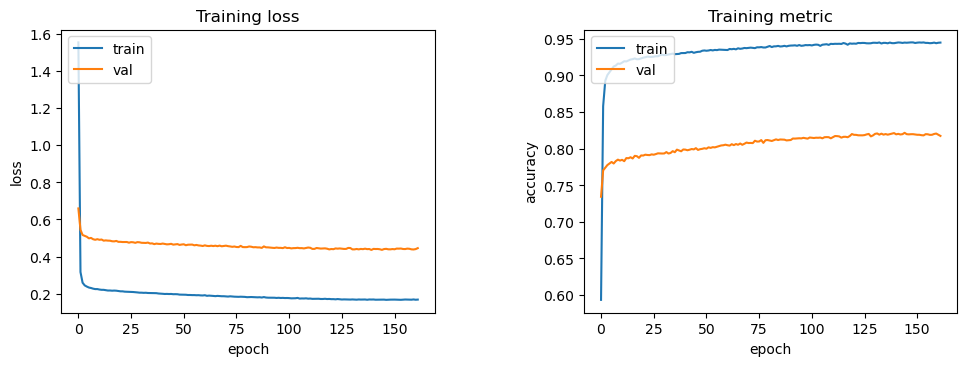

Epoch: 162 - Train Loss: 0.1685 / Validation Loss: 0.4454 / Train acc: 0.9447 / Val acc: 0.8173 / Learning Rate : 0.0000:   0%|          | 162/1000000 [05:42<586:52:45,  2.11s/it]


OT_post (method 1) loss: 0.44674252967039746 - accuracy: 0.8167718712258454 - f1: 0.8166892528533936
OT_post (method 2) loss: 0.4379654824733734 - accuracy: 0.8245843712258454 - f1: 0.8248137831687927
OT_post (method 3) loss: 0.44423551112413406 - accuracy: 0.8174276305857489 - f1: 0.8193974494934082
vanilla_post loss: 0.46496008336544037 - accuracy: 0.7961248867753623 - f1: 0.7953622341156006
Fold 2/5
Vocabulary Size :  23054


100%|██████████| 5909/5909 [00:00<00:00, 23127.43it/s]


Positive labels ratio (train set): 0.5059022635921303
Positive labels ratio (test set): 0.4902690810627856
Dataset initializing done
Starting training for model A


Epoch: 85 - Train Loss: 0.2143 / Validation Loss: 0.5117 / Train acc: 0.9184 / Val acc: 0.7909 / Learning Rate : 0.0000:   0%|          | 85/1000000 [03:09<610:55:49,  2.20s/it]

Training has converged after 85 epochs (lr < 1e-06)


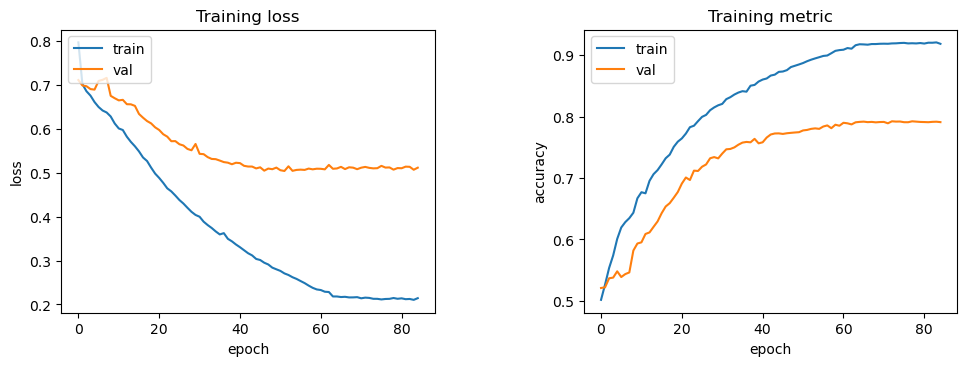

Epoch: 85 - Train Loss: 0.2143 / Validation Loss: 0.5117 / Train acc: 0.9184 / Val acc: 0.7909 / Learning Rate : 0.0000:   0%|          | 85/1000000 [03:09<619:25:39,  2.23s/it]


Starting training for model B


Epoch: 47 - Train Loss: 0.1811 / Validation Loss: 0.4377 / Train acc: 0.9342 / Val acc: 0.8264 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:47<625:50:55,  2.25s/it]

Training has converged after 47 epochs (lr < 1e-06)


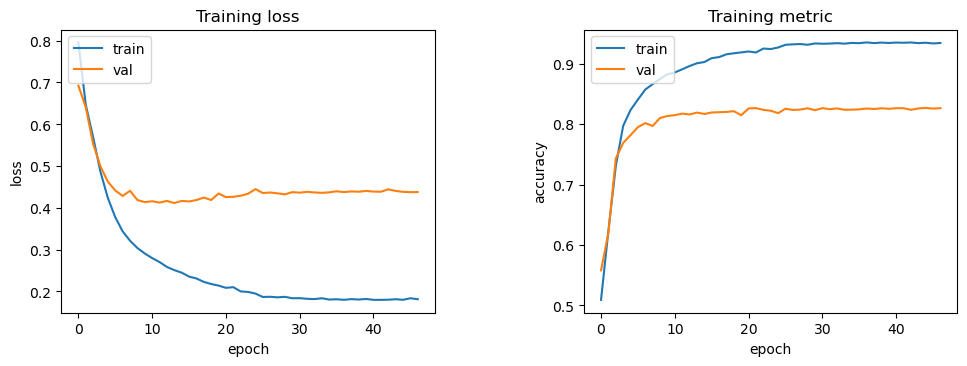

Epoch: 47 - Train Loss: 0.1811 / Validation Loss: 0.4377 / Train acc: 0.9342 / Val acc: 0.8264 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:47<635:25:09,  2.29s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.7378897968477612
fusion successful
fusion success

Epoch: 145 - Train Loss: 0.2003 / Validation Loss: 0.4648 / Train acc: 0.9315 / Val acc: 0.7987 / Learning Rate : 0.0000:   0%|          | 145/1000000 [05:22<594:06:29,  2.14s/it]

Training has converged after 145 epochs (lr < 1e-06)


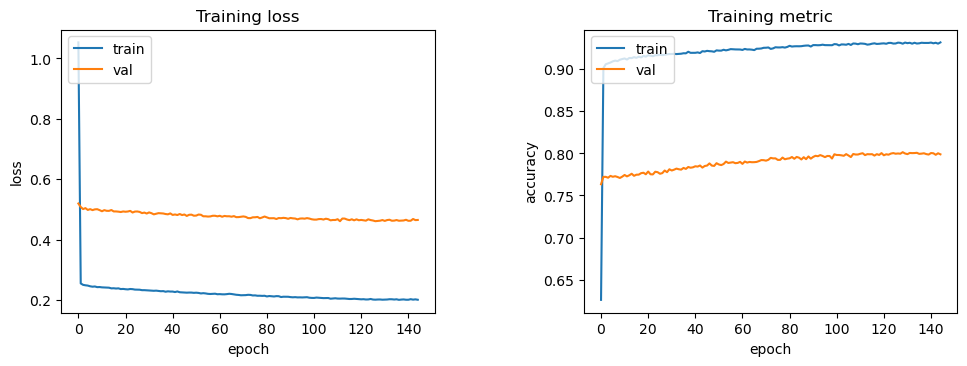

Epoch: 145 - Train Loss: 0.2003 / Validation Loss: 0.4648 / Train acc: 0.9315 / Val acc: 0.7987 / Learning Rate : 0.0000:   0%|          | 145/1000000 [05:22<617:19:44,  2.22s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 119 - Train Loss: 0.1949 / Validation Loss: 0.4585 / Train acc: 0.9320 / Val acc: 0.8072 / Learning Rate : 0.0000:   0%|          | 119/1000000 [04:15<582:55:05,  2.10s/it]

Training has converged after 119 epochs (lr < 1e-06)


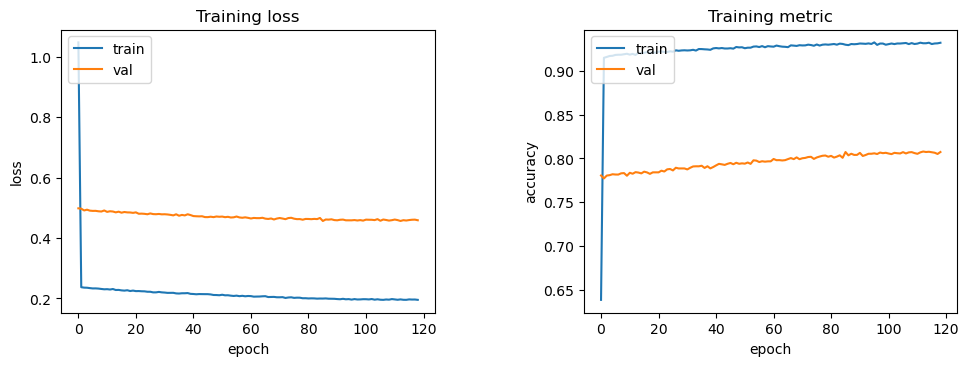

Epoch: 119 - Train Loss: 0.1949 / Validation Loss: 0.4585 / Train acc: 0.9320 / Val acc: 0.8072 / Learning Rate : 0.0000:   0%|          | 119/1000000 [04:16<597:44:59,  2.15s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 139 - Train Loss: 0.1918 / Validation Loss: 0.4611 / Train acc: 0.9326 / Val acc: 0.8062 / Learning Rate : 0.0000:   0%|          | 139/1000000 [04:50<575:57:00,  2.07s/it]

Training has converged after 139 epochs (lr < 1e-06)


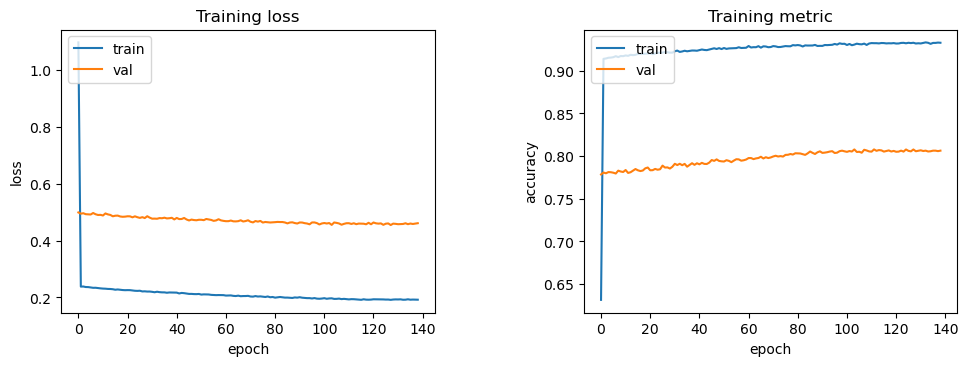

Epoch: 139 - Train Loss: 0.1918 / Validation Loss: 0.4611 / Train acc: 0.9326 / Val acc: 0.8062 / Learning Rate : 0.0000:   0%|          | 139/1000000 [04:50<581:02:32,  2.09s/it]


Starting retraining for model OT fusion (method 3)


Epoch: 172 - Train Loss: 0.1893 / Validation Loss: 0.4537 / Train acc: 0.9334 / Val acc: 0.8098 / Learning Rate : 0.0000:   0%|          | 172/1000000 [05:59<581:45:09,  2.09s/it]

Training has converged after 172 epochs (lr < 1e-06)


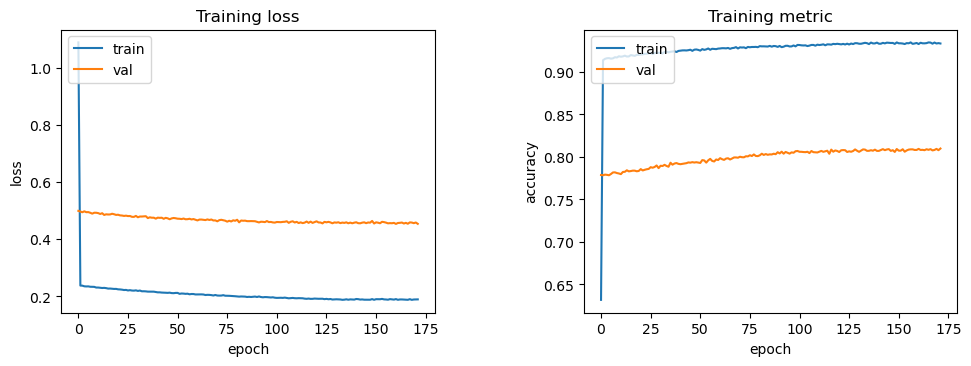

Epoch: 172 - Train Loss: 0.1893 / Validation Loss: 0.4537 / Train acc: 0.9334 / Val acc: 0.8098 / Learning Rate : 0.0000:   0%|          | 172/1000000 [05:59<580:38:05,  2.09s/it]


OT_post (method 1) loss: 0.4579859947164853 - accuracy: 0.8038008376579422 - f1: 0.8050431609153748
OT_post (method 2) loss: 0.4583005979657173 - accuracy: 0.8063209799939832 - f1: 0.8062278032302856
OT_post (method 3) loss: 0.4577472110589345 - accuracy: 0.8070560459912756 - f1: 0.8084278106689453
vanilla_post loss: 0.46284446368614834 - accuracy: 0.7997612063778581 - f1: 0.7991200089454651
Fold 3/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 14554.29it/s]


Positive labels ratio (train set): 0.5016289401311614
Positive labels ratio (test set): 0.5073616517177187
Dataset initializing done
Starting training for model A


Epoch: 94 - Train Loss: 0.1751 / Validation Loss: 0.4949 / Train acc: 0.9362 / Val acc: 0.8087 / Learning Rate : 0.0000:   0%|          | 94/1000000 [03:27<612:05:17,  2.20s/it]

Training has converged after 94 epochs (lr < 1e-06)


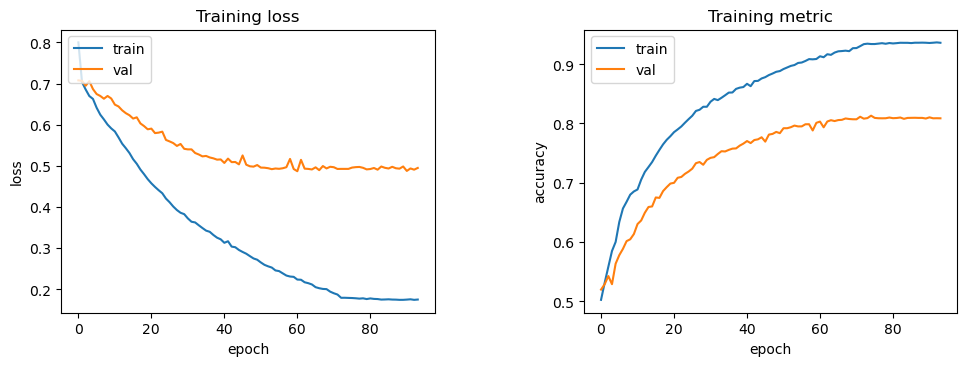

Epoch: 94 - Train Loss: 0.1751 / Validation Loss: 0.4949 / Train acc: 0.9362 / Val acc: 0.8087 / Learning Rate : 0.0000:   0%|          | 94/1000000 [03:27<613:59:37,  2.21s/it]


Starting training for model B


Epoch: 49 - Train Loss: 0.1495 / Validation Loss: 0.4014 / Train acc: 0.9484 / Val acc: 0.8458 / Learning Rate : 0.0000:   0%|          | 49/1000000 [01:46<613:30:01,  2.21s/it]

Training has converged after 49 epochs (lr < 1e-06)


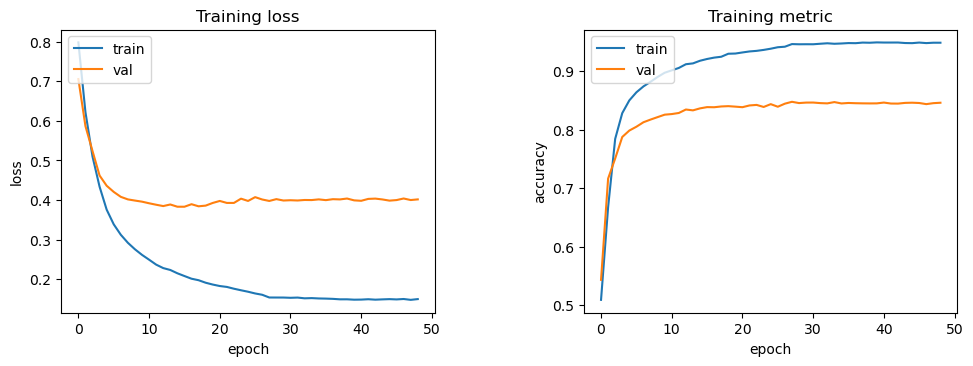

Epoch: 49 - Train Loss: 0.1495 / Validation Loss: 0.4014 / Train acc: 0.9484 / Val acc: 0.8458 / Learning Rate : 0.0000:   0%|          | 49/1000000 [01:47<607:07:18,  2.19s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.0033686150854442126
fusion successful
fusion succ

Epoch: 100 - Train Loss: 0.1701 / Validation Loss: 0.4388 / Train acc: 0.9462 / Val acc: 0.8144 / Learning Rate : 0.0000:   0%|          | 100/1000000 [03:28<576:21:53,  2.08s/it]

Training has converged after 100 epochs (lr < 1e-06)


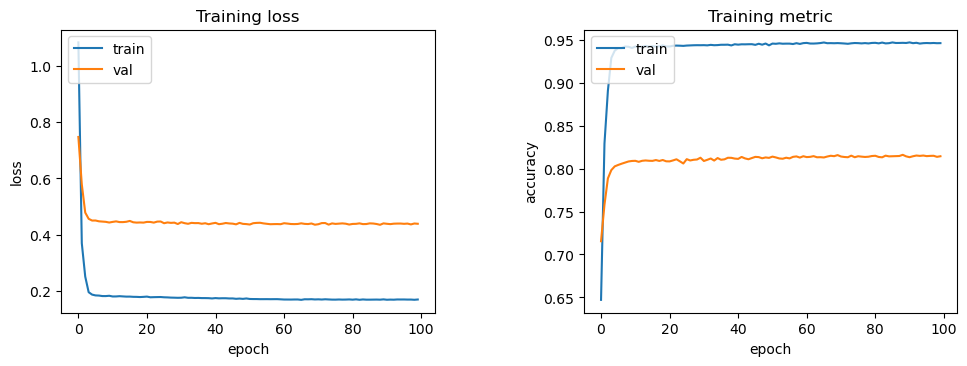

Epoch: 100 - Train Loss: 0.1701 / Validation Loss: 0.4388 / Train acc: 0.9462 / Val acc: 0.8144 / Learning Rate : 0.0000:   0%|          | 100/1000000 [03:28<580:03:11,  2.09s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 43 - Train Loss: 0.1742 / Validation Loss: 0.4074 / Train acc: 0.9427 / Val acc: 0.8270 / Learning Rate : 0.0000:   0%|          | 43/1000000 [01:31<596:47:57,  2.15s/it]

Training has converged after 43 epochs (lr < 1e-06)


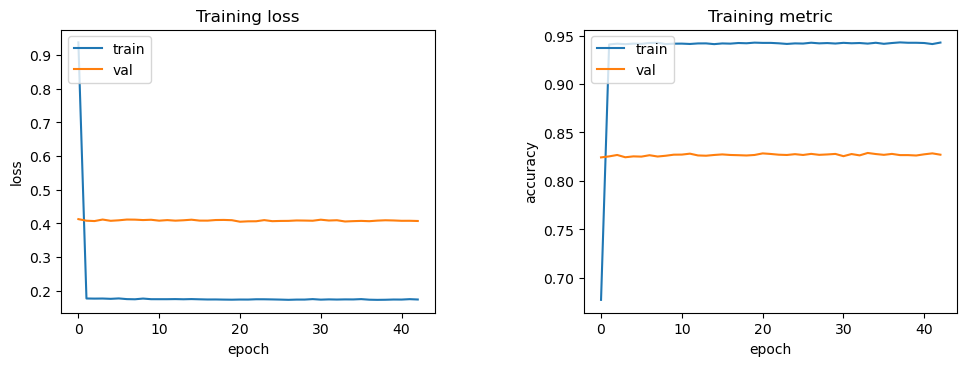

Epoch: 43 - Train Loss: 0.1742 / Validation Loss: 0.4074 / Train acc: 0.9427 / Val acc: 0.8270 / Learning Rate : 0.0000:   0%|          | 43/1000000 [01:31<590:20:22,  2.13s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 50 - Train Loss: 0.1741 / Validation Loss: 0.4067 / Train acc: 0.9420 / Val acc: 0.8283 / Learning Rate : 0.0000:   0%|          | 50/1000000 [01:46<590:12:13,  2.12s/it]

Training has converged after 50 epochs (lr < 1e-06)


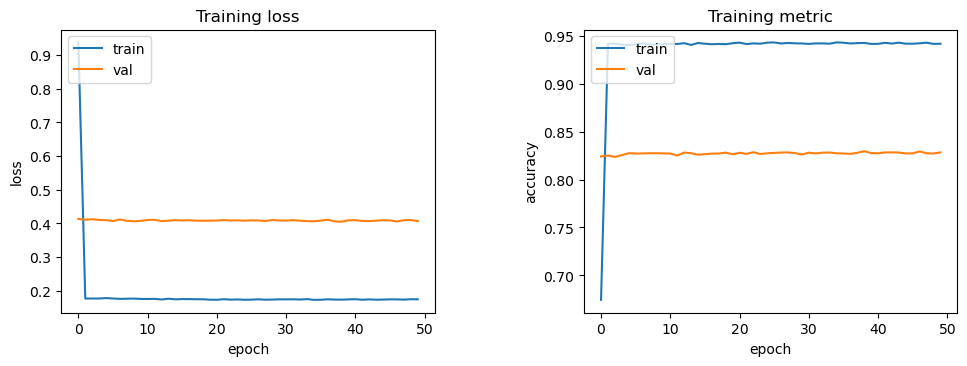

Epoch: 50 - Train Loss: 0.1741 / Validation Loss: 0.4067 / Train acc: 0.9420 / Val acc: 0.8283 / Learning Rate : 0.0000:   0%|          | 50/1000000 [01:46<592:02:23,  2.13s/it]


Starting retraining for model OT fusion (method 3)


Epoch: 48 - Train Loss: 0.1728 / Validation Loss: 0.4101 / Train acc: 0.9426 / Val acc: 0.8265 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:42<592:17:47,  2.13s/it]

Training has converged after 48 epochs (lr < 1e-06)


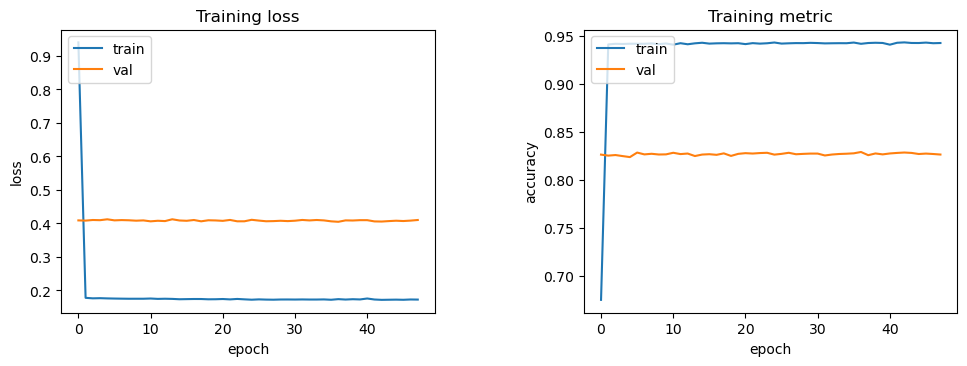

Epoch: 48 - Train Loss: 0.1728 / Validation Loss: 0.4101 / Train acc: 0.9426 / Val acc: 0.8265 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:42<595:18:46,  2.14s/it]


OT_post (method 1) loss: 0.40772871673107147 - accuracy: 0.8267794355445247 - f1: 0.8272127509117126
OT_post (method 2) loss: 0.4081408108274142 - accuracy: 0.8282342903880866 - f1: 0.8277204036712646
OT_post (method 3) loss: 0.40901798009872437 - accuracy: 0.8268041140192539 - f1: 0.8273819088935852
vanilla_post loss: 0.43486960232257843 - accuracy: 0.8169691542569193 - f1: 0.8148586750030518
Fold 4/5
Vocabulary Size :  23075


100%|██████████| 5909/5909 [00:00<00:00, 13903.64it/s]


Positive labels ratio (train set): 0.5009519779987307
Positive labels ratio (test set): 0.5100693856828566
Dataset initializing done
Starting training for model A


Epoch: 83 - Train Loss: 0.2250 / Validation Loss: 0.5151 / Train acc: 0.9155 / Val acc: 0.7911 / Learning Rate : 0.0000:   0%|          | 83/1000000 [03:06<618:50:23,  2.23s/it]

Training has converged after 83 epochs (lr < 1e-06)


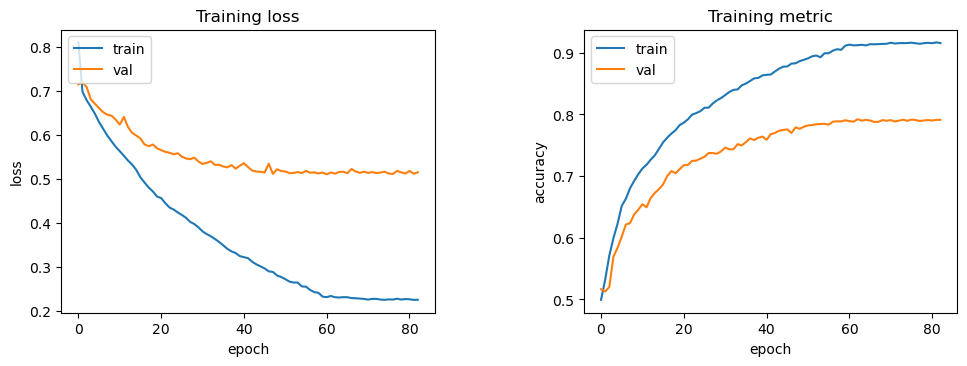

Epoch: 83 - Train Loss: 0.2250 / Validation Loss: 0.5151 / Train acc: 0.9155 / Val acc: 0.7911 / Learning Rate : 0.0000:   0%|          | 83/1000000 [03:06<625:01:54,  2.25s/it]


Starting training for model B


Epoch: 47 - Train Loss: 0.1776 / Validation Loss: 0.4317 / Train acc: 0.9344 / Val acc: 0.8260 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:44<617:12:56,  2.22s/it]

Training has converged after 47 epochs (lr < 1e-06)


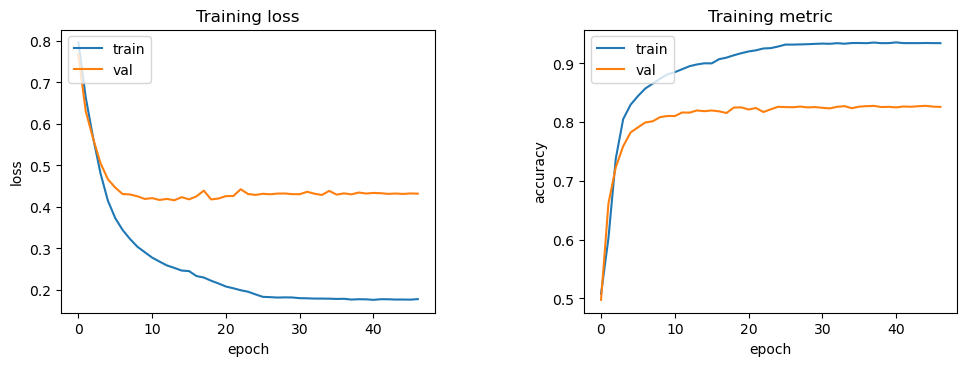

Epoch: 47 - Train Loss: 0.1776 / Validation Loss: 0.4317 / Train acc: 0.9344 / Val acc: 0.8260 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:45<620:46:39,  2.23s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.059469549687055756
fusion successful
fusion succe

Epoch: 175 - Train Loss: 0.2060 / Validation Loss: 0.4667 / Train acc: 0.9304 / Val acc: 0.7934 / Learning Rate : 0.0000:   0%|          | 175/1000000 [06:15<599:51:30,  2.16s/it]

Training has converged after 175 epochs (lr < 1e-06)


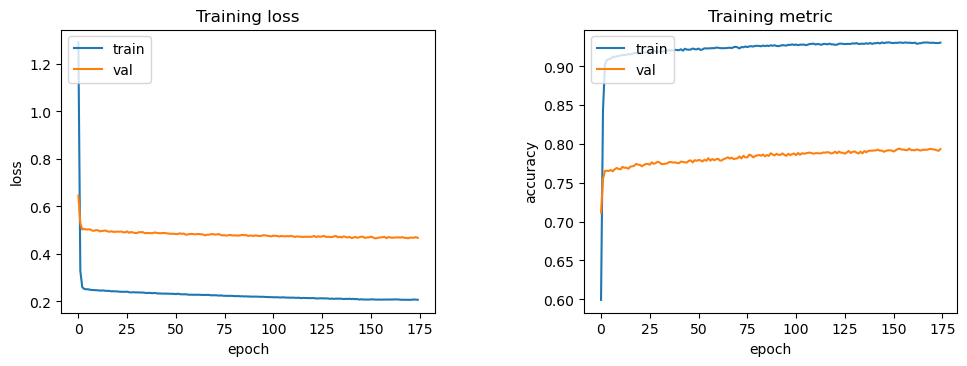

Epoch: 175 - Train Loss: 0.2060 / Validation Loss: 0.4667 / Train acc: 0.9304 / Val acc: 0.7934 / Learning Rate : 0.0000:   0%|          | 175/1000000 [06:16<596:54:01,  2.15s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 119 - Train Loss: 0.2147 / Validation Loss: 0.4553 / Train acc: 0.9273 / Val acc: 0.7979 / Learning Rate : 0.0000:   0%|          | 119/1000000 [04:16<592:44:46,  2.13s/it]

Training has converged after 119 epochs (lr < 1e-06)


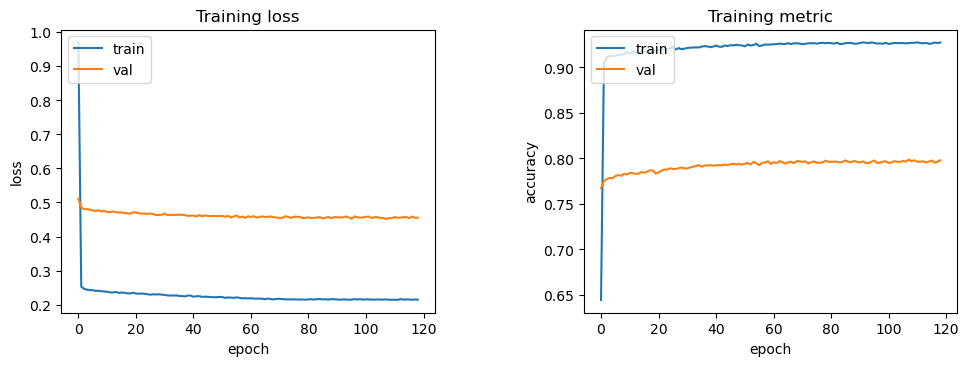

Epoch: 119 - Train Loss: 0.2147 / Validation Loss: 0.4553 / Train acc: 0.9273 / Val acc: 0.7979 / Learning Rate : 0.0000:   0%|          | 119/1000000 [04:16<598:21:32,  2.15s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 133 - Train Loss: 0.2094 / Validation Loss: 0.4524 / Train acc: 0.9283 / Val acc: 0.7998 / Learning Rate : 0.0000:   0%|          | 133/1000000 [04:42<588:03:07,  2.12s/it]

Training has converged after 133 epochs (lr < 1e-06)


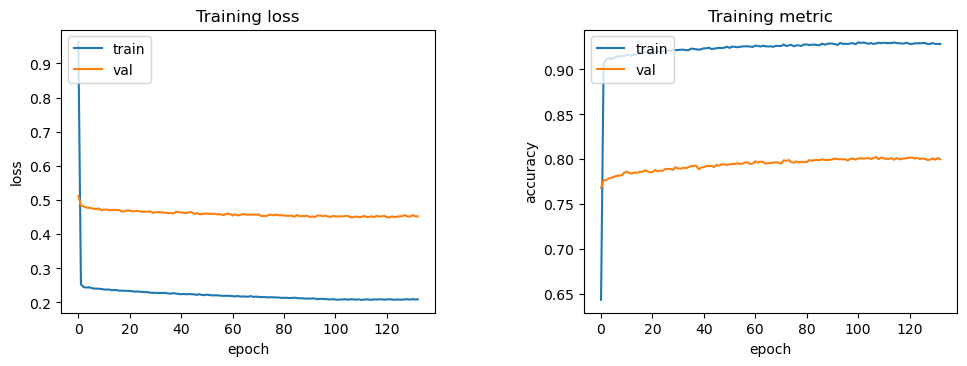

Epoch: 133 - Train Loss: 0.2094 / Validation Loss: 0.4524 / Train acc: 0.9283 / Val acc: 0.7998 / Learning Rate : 0.0000:   0%|          | 133/1000000 [04:42<589:55:28,  2.12s/it]


Starting retraining for model OT fusion (method 3)


Epoch: 113 - Train Loss: 0.2118 / Validation Loss: 0.4546 / Train acc: 0.9281 / Val acc: 0.7973 / Learning Rate : 0.0000:   0%|          | 113/1000000 [03:59<580:10:11,  2.09s/it]

Training has converged after 113 epochs (lr < 1e-06)


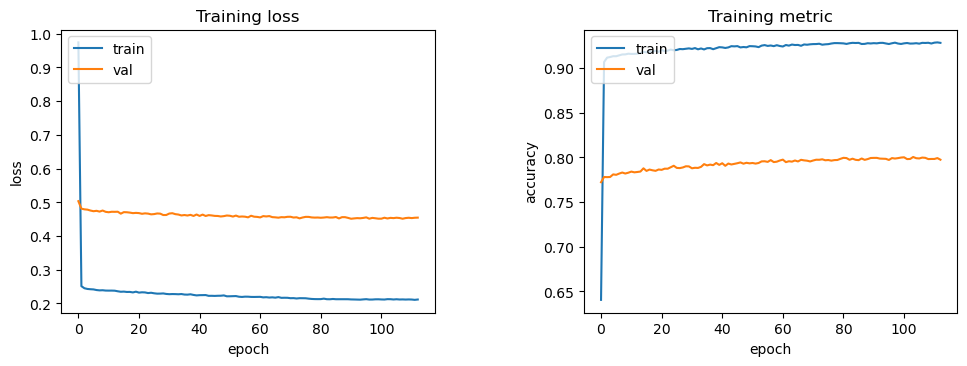

Epoch: 113 - Train Loss: 0.2118 / Validation Loss: 0.4546 / Train acc: 0.9281 / Val acc: 0.7973 / Learning Rate : 0.0000:   0%|          | 113/1000000 [03:59<588:26:47,  2.12s/it]


OT_post (method 1) loss: 0.4553909773627917 - accuracy: 0.7980942341681709 - f1: 0.7981045842170715
OT_post (method 2) loss: 0.4514879956841469 - accuracy: 0.7999239667945247 - f1: 0.7992892265319824
OT_post (method 3) loss: 0.45139892647663754 - accuracy: 0.7993863285950661 - f1: 0.798443078994751
vanilla_post loss: 0.4692566667993863 - accuracy: 0.7924616661025873 - f1: 0.7916736602783203
Fold 5/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 21605.03it/s]


Positive labels ratio (train set): 0.503448275862069
Positive labels ratio (test set): 0.5000846166864106
Dataset initializing done
Starting training for model A


Epoch: 98 - Train Loss: 0.1852 / Validation Loss: 0.5107 / Train acc: 0.9298 / Val acc: 0.7995 / Learning Rate : 0.0000:   0%|          | 98/1000000 [03:38<628:06:19,  2.26s/it]

Training has converged after 98 epochs (lr < 1e-06)


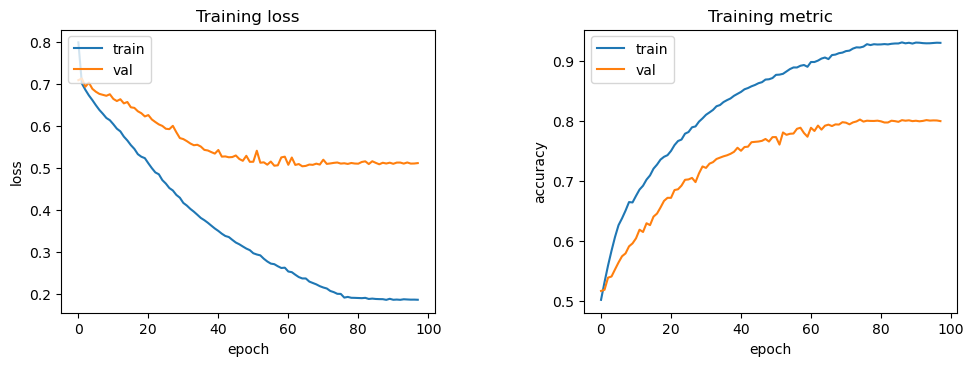

Epoch: 98 - Train Loss: 0.1852 / Validation Loss: 0.5107 / Train acc: 0.9298 / Val acc: 0.7995 / Learning Rate : 0.0000:   0%|          | 98/1000000 [03:38<618:57:36,  2.23s/it]


Starting training for model B


Epoch: 51 - Train Loss: 0.1439 / Validation Loss: 0.4220 / Train acc: 0.9494 / Val acc: 0.8325 / Learning Rate : 0.0000:   0%|          | 51/1000000 [01:54<622:55:19,  2.24s/it]

Training has converged after 51 epochs (lr < 1e-06)


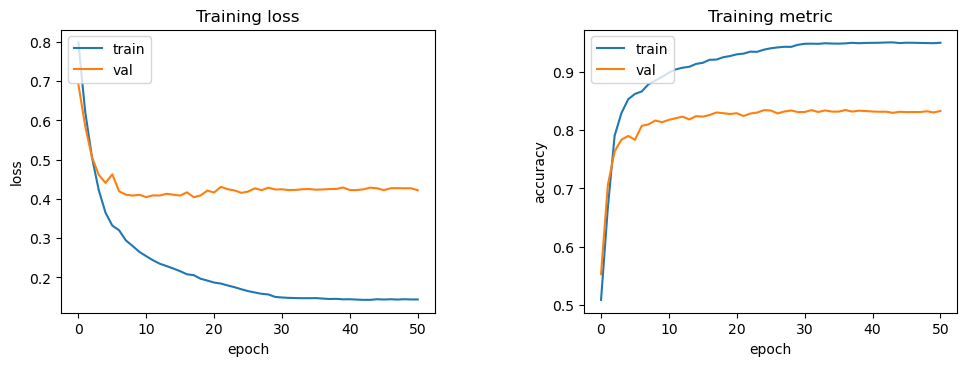

Epoch: 51 - Train Loss: 0.1439 / Validation Loss: 0.4220 / Train acc: 0.9494 / Val acc: 0.8325 / Learning Rate : 0.0000:   0%|          | 51/1000000 [01:54<624:41:54,  2.25s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.9978629725146048
fusion successful
fusion success

Epoch: 151 - Train Loss: 0.1771 / Validation Loss: 0.4642 / Train acc: 0.9437 / Val acc: 0.7923 / Learning Rate : 0.0000:   0%|          | 151/1000000 [05:21<591:38:04,  2.13s/it]

Training has converged after 151 epochs (lr < 1e-06)


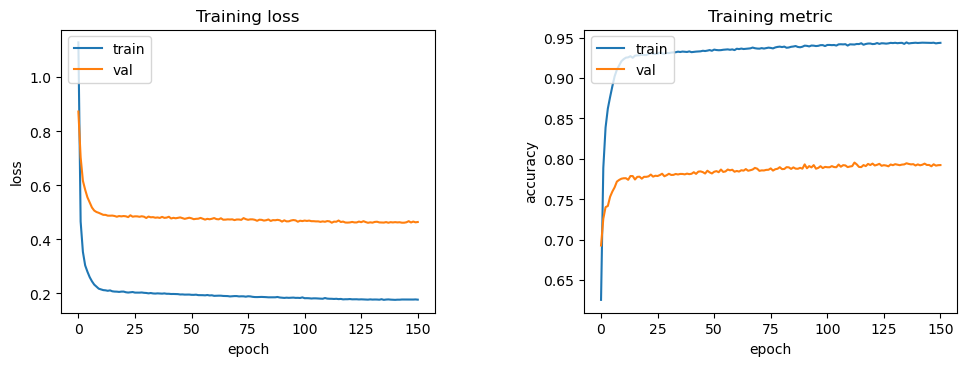

Epoch: 151 - Train Loss: 0.1771 / Validation Loss: 0.4642 / Train acc: 0.9437 / Val acc: 0.7923 / Learning Rate : 0.0000:   0%|          | 151/1000000 [05:21<591:39:20,  2.13s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 100 - Train Loss: 0.1733 / Validation Loss: 0.4786 / Train acc: 0.9406 / Val acc: 0.7925 / Learning Rate : 0.0000:   0%|          | 100/1000000 [03:32<585:51:24,  2.11s/it]

Training has converged after 100 epochs (lr < 1e-06)


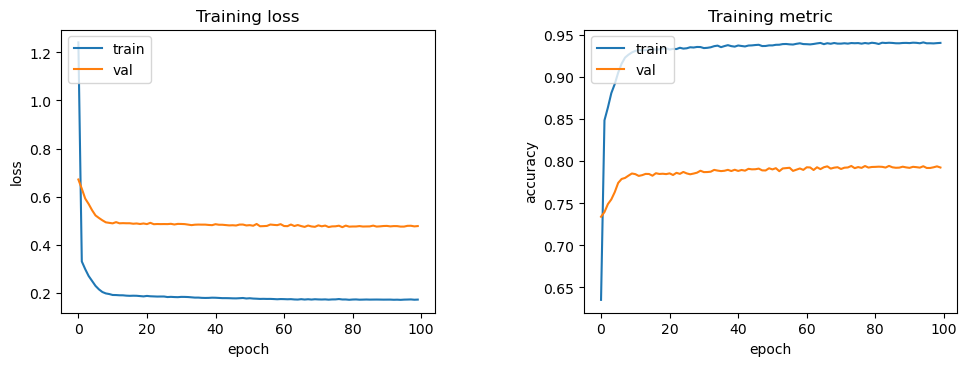

Epoch: 100 - Train Loss: 0.1733 / Validation Loss: 0.4786 / Train acc: 0.9406 / Val acc: 0.7925 / Learning Rate : 0.0000:   0%|          | 100/1000000 [03:32<590:21:02,  2.13s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 102 - Train Loss: 0.1735 / Validation Loss: 0.4799 / Train acc: 0.9400 / Val acc: 0.7912 / Learning Rate : 0.0000:   0%|          | 102/1000000 [03:34<585:37:12,  2.11s/it]

Training has converged after 102 epochs (lr < 1e-06)


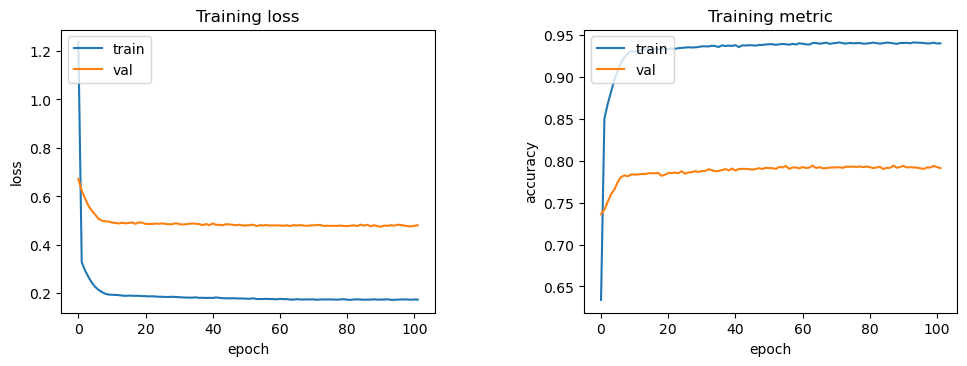

Epoch: 102 - Train Loss: 0.1735 / Validation Loss: 0.4799 / Train acc: 0.9400 / Val acc: 0.7912 / Learning Rate : 0.0000:   0%|          | 102/1000000 [03:34<583:41:05,  2.10s/it]


Starting retraining for model OT fusion (method 3)


Epoch: 85 - Train Loss: 0.1779 / Validation Loss: 0.4817 / Train acc: 0.9386 / Val acc: 0.7904 / Learning Rate : 0.0000:   0%|          | 85/1000000 [02:59<587:08:58,  2.11s/it]

Training has converged after 85 epochs (lr < 1e-06)


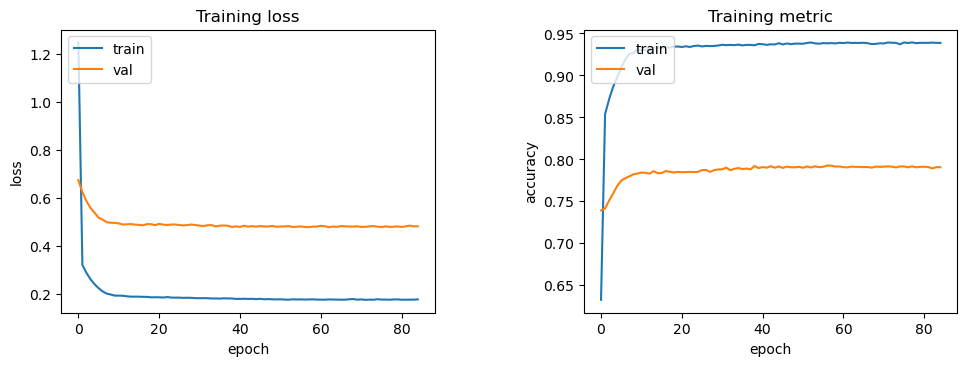

Epoch: 85 - Train Loss: 0.1779 / Validation Loss: 0.4817 / Train acc: 0.9386 / Val acc: 0.7904 / Learning Rate : 0.0000:   0%|          | 85/1000000 [02:59<588:05:02,  2.12s/it]


OT_post (method 1) loss: 0.48680110772450763 - accuracy: 0.7907406362815884 - f1: 0.7921814322471619
OT_post (method 2) loss: 0.48048699895540875 - accuracy: 0.7914063675165464 - f1: 0.7920121550559998
OT_post (method 3) loss: 0.4797725131114324 - accuracy: 0.7916478640192539 - f1: 0.7908275723457336
vanilla_post loss: 0.4709027980764707 - accuracy: 0.7912976647111913 - f1: 0.7903198599815369
CPU times: total: 2h 8min 37s
Wall time: 1h 56min 41s


In [20]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i in range(FOLDS):
        print(f'Fold {i + 1}/{FOLDS}')

        # get training, test set
        train_set, test_set = datasets.pop()

        # build generators
        train_iterator, test_iterator, voc_size, pad_idx, embedding = build_generators(train_set, test_set, device, batch_size=512)

        # train parent models
        train_parent = lambda x: train_early_stopping(model_name=x,
                                                      train_iter=train_iterator,
                                                      valid_iter=test_iterator,
                                                      embedding=embedding,
                                                      pad_idx=pad_idx,
                                                      voc_size=voc_size,
                                                      device=device,
                                                      lr=LEARNING_RATE,
                                                      save=False)
        print('Starting training for model A')
        modelA = train_parent('A')
        print('Starting training for model B')
        modelB = train_parent('B')

        # model fusion
        # 1) vanilla
        model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx, voc_size=voc_size, embedding=embedding, device=device)
        # 2) optimal transport
        N_TRIALS = 50
        variations = ['standard', 'multihead', 'cross-multihead']
        # 2.1) method 1
        variation = variations[0]
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device, variation=variation), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight (method 1):', best_weighting_factor)
        model_fusion_1 = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size, device, fusion_ratio=best_weighting_factor, variation=variation)
        # 2.2) method 2
        variation = variations[1]
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device, variation=variation), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight (method 2):', best_weighting_factor)
        model_fusion_2 = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size, device, fusion_ratio=best_weighting_factor, variation=variation)
        # 2.3) method 3
        variation = variations[2]
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device, variation=variation), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight (method 3):', best_weighting_factor)
        model_fusion_3 = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size, device, fusion_ratio=best_weighting_factor, variation=variation)

        # evaluate
        # ensure all models on same device
        model_to_cpu = lambda x: x.to(device)
        modelA = model_to_cpu(modelA)
        modelB = model_to_cpu(modelB)
        model_random = new_model(embedding, pad_idx, voc_size, device, n_head=N_HEADS)
        model_fusion_1 = model_to_cpu(model_fusion_1)
        model_fusion_2 = model_to_cpu(model_fusion_2)
        model_fusion_3 = model_to_cpu(model_fusion_3)
        model_fusion_vanilla = model_to_cpu(model_fusion_vanilla)

        # test models
        for name, model in zip(('A', 'B', 'random', 'OT_pre (method 1)', 'OT_pre (method 2)', 'OT_pre (method 3)', 'vanilla_pre'),
                               (modelA, modelB, model_random, model_fusion_1, model_fusion_2, model_fusion_3, model_fusion_vanilla)):
            loss, acc, f1 = validation(model, test_iterator, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

            # put into cpu
            to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
            loss = to_cpu(loss)
            acc = to_cpu(acc)
            f1 = to_cpu(f1)

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

        # retraining
        retrain = lambda x: train(model=x,
                                  iterator=train_iterator,
                                  valid_iter=test_iterator,
                                  optimizer=torch.optim.SGD(x.parameters(), lr=LEARNING_RATE),
                                  criterion=nn.CrossEntropyLoss(),
                                  epoch=EPOCHS,
                                  clip=1,
                                  device=device)
        # 1) vanilla
        # train with early stopping
        print('Starting retraining for model vanilla fusion')
        retrain(model_fusion_vanilla)

        # 2) optimal transport
        # train with early stopping
        print('Starting retraining for model OT fusion (method 1)')
        retrain(model_fusion_1)
        print('Starting retraining for model OT fusion (method 2)')
        retrain(model_fusion_2)
        print('Starting retraining for model OT fusion (method 3)')
        retrain(model_fusion_3)

        # evaluate
        # ensure all models on same device
        model_fusion_1 = model_to_cpu(model_fusion_1)
        model_fusion_2 = model_to_cpu(model_fusion_2)
        model_fusion_3 = model_to_cpu(model_fusion_3)
        model_fusion_vanilla = model_to_cpu(model_fusion_vanilla)

        # test models
        for name, model in zip(('OT_post (method 1)', 'OT_post (method 2)', 'OT_post (method 3)', 'vanilla_post'), (model_fusion_1, model_fusion_2, model_fusion_3, model_fusion_vanilla)):
            loss, acc, f1 = validation(model, test_iterator, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

            # put into cpu
            to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
            loss = to_cpu(loss)
            acc = to_cpu(acc)
            f1 = to_cpu(f1)

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

### Export as LaTeX

In [24]:
model_names_latex = ['Model A', 'Model B', 'Vanilla', 'Vanilla (retraining)', 'Optimal transport (method 1)', 'Optimal transport (method 1 - retraining)',
                     'Optimal transport (method 2)', 'Optimal transport (method 2 - retraining)', 'Optimal transport (method 3)', 'Optimal transport (method 3 - retraining)', 'Untrained model (baseline)']

In [25]:
latex = scores_to_latex(scores, model_names_latex)

                                                   loss  \
A                    [0.447, 0.472, 0.441, 0.46, 0.454]   
B                   [0.399, 0.438, 0.406, 0.433, 0.425]   
vanilla_pre          [1.339, 0.506, 0.915, 0.82, 0.772]   
vanilla_post        [0.465, 0.463, 0.435, 0.469, 0.471]   
OT_pre (method 1)    [0.79, 0.504, 0.409, 0.487, 0.712]   
OT_post (method 1)  [0.447, 0.458, 0.408, 0.455, 0.487]   
OT_pre (method 2)   [0.788, 0.501, 0.414, 0.485, 0.711]   
OT_post (method 2)   [0.438, 0.458, 0.408, 0.451, 0.48]   
OT_pre (method 3)      [0.788, 0.5, 0.41, 0.486, 0.706]   
OT_post (method 3)   [0.444, 0.458, 0.409, 0.451, 0.48]   
random               [0.806, 0.811, 0.72, 0.743, 0.776]   

                                               accuracy  \
A                   [0.829, 0.819, 0.834, 0.817, 0.822]   
B                   [0.848, 0.826, 0.844, 0.826, 0.831]   
vanilla_pre         [0.579, 0.773, 0.682, 0.666, 0.718]   
vanilla_post          [0.796, 0.8, 0.817, 0.792, 0.791]

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\DL Project\CV\utils.py:925: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(index=True,


In [27]:
# save as latex (in text format) (optional)
with open('./Output/scores_different_seeds_multihead.txt','w') as dat:
    dat.write(str(latex))